In [1]:
from __future__ import division, print_function
import sys, os, glob, time, warnings, gc
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, vstack, hstack
import fitsio
from astropy.io import fits

from scipy.optimize import root_scalar

In [2]:
params = {'legend.fontsize': 'large',
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large',
         'figure.facecolor':'w'} 
plt.rcParams.update(params)

-------
## Variation in GAIA->DECam transformation

In [3]:
sweep_list = ['sweep-180p010-190p015.fits', 'sweep-190p010-200p015.fits']

cat = []
for sweep_fn in sweep_list:
    tmp = fitsio.read('/Users/rongpu/Downloads/'+sweep_fn, columns=['GAIA_PHOT_G_MEAN_MAG'])
    idx = np.where(tmp['GAIA_PHOT_G_MEAN_MAG']!=0)[0]
    tmp = fitsio.read('/Users/rongpu/Downloads/'+sweep_fn, rows=idx)
    tmp = Table(tmp)
    cat.append(tmp)
    
cat = vstack(cat)
print(len(cat))

299634


BP-RP lower bound: 0.635
BP-RP upper bound: 2.743


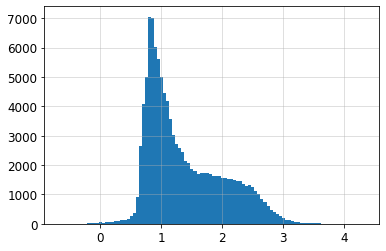

In [4]:
mask = (cat['GAIA_PHOT_G_MEAN_MAG']>7) & (cat['GAIA_PHOT_G_MEAN_MAG']<19)
mask &= np.isfinite(cat['GAIA_PHOT_BP_MEAN_MAG']-cat['GAIA_PHOT_RP_MEAN_MAG'])

bp_rp_min = np.percentile((cat['GAIA_PHOT_BP_MEAN_MAG']-cat['GAIA_PHOT_RP_MEAN_MAG'])[mask], 2.5)
bp_rp_max = np.percentile((cat['GAIA_PHOT_BP_MEAN_MAG']-cat['GAIA_PHOT_RP_MEAN_MAG'])[mask], 97.5)
print('BP-RP lower bound: {:.3f}'.format(bp_rp_min))
print('BP-RP upper bound: {:.3f}'.format(bp_rp_max))

plt.hist((cat['GAIA_PHOT_BP_MEAN_MAG']-cat['GAIA_PHOT_RP_MEAN_MAG'])[mask], 100)
plt.grid(alpha=0.5)
plt.show()

In [5]:
mask = cat['MASKBITS']==0
print(np.sum(mask))
cat = cat[mask]

mask = cat['TYPE']=='PSF '
print(np.sum(mask))
cat = cat[mask]

mask = cat['FRACFLUX_R']<0.1
print(np.sum(mask))
cat = cat[mask]

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    cat['gmag'] = 22.5 - 2.5*np.log10(cat['FLUX_G'])
    cat['rmag'] = 22.5 - 2.5*np.log10(cat['FLUX_R'])
    cat['zmag'] = 22.5 - 2.5*np.log10(cat['FLUX_Z'])
    cat['w1mag'] = 22.5 - 2.5*np.log10(cat['FLUX_W1'])
    cat['w2mag'] = 22.5 - 2.5*np.log10(cat['FLUX_W2'])

256746
246825
242940


In [6]:
a = {'g_min' :  0.22}

In [7]:
mask = (cat['GAIA_PHOT_G_MEAN_MAG']>16) & ((cat['GAIA_PHOT_G_MEAN_MAG']<18.5))

g_min, g_max = np.percentile((cat['gmag']-cat['GAIA_PHOT_G_MEAN_MAG'])[mask], [2.5, 97.5])
print('DECaLS_G - GAIA_G range: {:.2f}, {:.2f} '.format(g_min, g_max))

r_min, r_max = np.percentile((cat['rmag']-cat['GAIA_PHOT_G_MEAN_MAG'])[mask], [2.5, 97.5])
print('DECaLS_R - GAIA_G range: {:.2f}, {:.2f} '.format(r_min, r_max))

z_min, z_max = np.percentile((cat['zmag']-cat['GAIA_PHOT_G_MEAN_MAG'])[mask], [2.5, 97.5])
print('DECaLS_Z - GAIA_G range: {:.2f}, {:.2f} '.format(z_min, z_max))

DECaLS_G - GAIA_G range: 0.22, 1.90 
DECaLS_R - GAIA_G range: -0.17, 0.41 
DECaLS_Z - GAIA_G range: -1.57, -0.09 


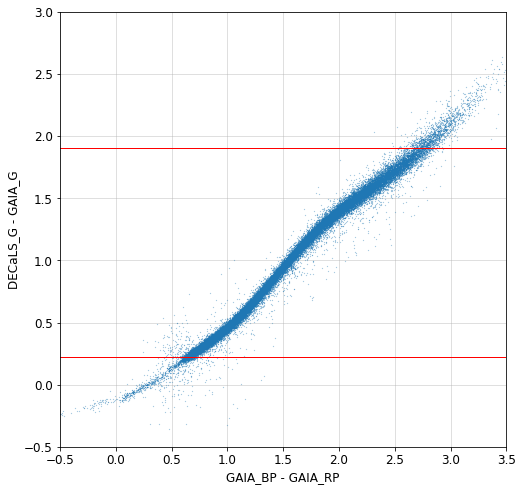

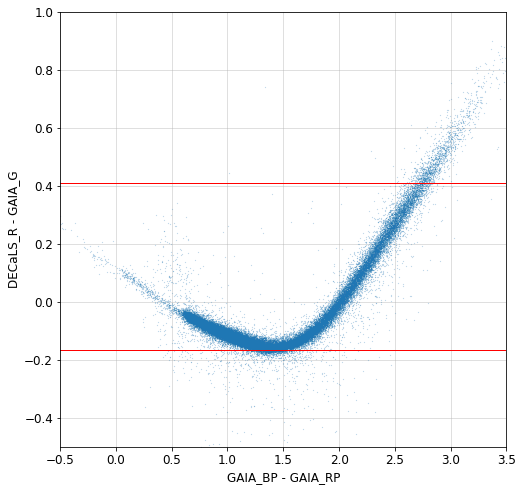

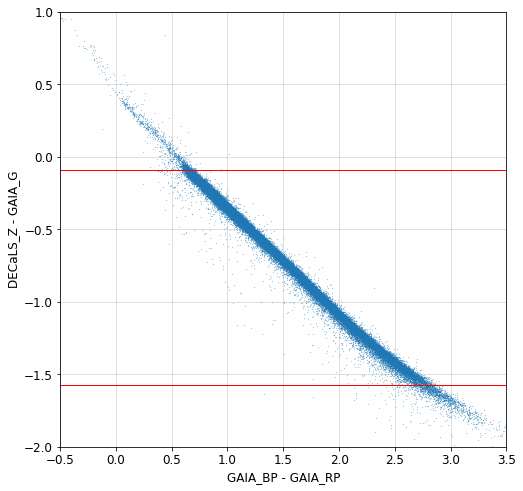

In [8]:
plt.figure(figsize=(8, 8))
plt.plot((cat['GAIA_PHOT_BP_MEAN_MAG']-cat['GAIA_PHOT_RP_MEAN_MAG'])[mask], (cat['gmag']-cat['GAIA_PHOT_G_MEAN_MAG'])[mask], '.', ms=0.3)
plt.axhline(g_min, lw=1, color='r')
plt.axhline(g_max, lw=1, color='r')
plt.xlabel('GAIA_BP - GAIA_RP')
plt.ylabel('DECaLS_G - GAIA_G')
plt.axis([-0.5, 3.5, -0.5, 3.])
plt.grid(alpha=0.5)
plt.show()

plt.figure(figsize=(8, 8))
plt.plot((cat['GAIA_PHOT_BP_MEAN_MAG']-cat['GAIA_PHOT_RP_MEAN_MAG'])[mask], (cat['rmag']-cat['GAIA_PHOT_G_MEAN_MAG'])[mask], '.', ms=0.2)
plt.axhline(r_min, lw=1, color='r')
plt.axhline(r_max, lw=1, color='r')
plt.xlabel('GAIA_BP - GAIA_RP')
plt.ylabel('DECaLS_R - GAIA_G')
plt.axis([-0.5, 3.5, -0.5, 1])
plt.grid(alpha=0.5)
plt.show()

plt.figure(figsize=(8, 8))
plt.plot((cat['GAIA_PHOT_BP_MEAN_MAG']-cat['GAIA_PHOT_RP_MEAN_MAG'])[mask], (cat['zmag']-cat['GAIA_PHOT_G_MEAN_MAG'])[mask], '.', ms=0.3)
plt.axhline(z_min, lw=1, color='r')
plt.axhline(z_max, lw=1, color='r')
plt.xlabel('GAIA_BP - GAIA_RP')
plt.ylabel('DECaLS_Z - GAIA_G')
plt.axis([-0.5, 3.5, -2, 1.])
plt.grid(alpha=0.5)
plt.show()

-------
## Variation in Moffat parameters

In [9]:
surveyccd = fitsio.read('/Users/rongpu/Documents/Data/desi_misc/survey-ccds-decam-dr9-cut.fits.gz', columns=['expnum', 'ccd_cuts'])
surveyccd = Table(surveyccd)
print(len(surveyccd))

mask = surveyccd['ccd_cuts']==0
surveyccd = surveyccd[mask]
print(len(surveyccd))

6388338
4881022


In [10]:
moffat_params = Table.read('/Users/rongpu/Documents/Data/desi_misc/bright_star_profiles/survey-ccds-decam-dr9-cut-psfex-moffat-params-subsample.fits')
print(len(moffat_params))

mask = np.in1d(moffat_params['expnum'], np.unique(surveyccd['expnum']))
moffat_params = moffat_params[mask]
print(len(moffat_params))

120616
91802


In [11]:
moffat_params[:3]

expnum,ccdname,psf_patch_ver,moffat_alpha,moffat_beta,sum_diff,fit_original,failure,filter
int64,bytes3,bytes7,float64,float64,float64,float64,bool,bytes1
229623,S29,d683d99,1.28679689596447,2.937979458229918,0.000707554048858583,1.0000000240511808,False,g
229623,S30,d683d99,1.2933592782928862,2.943162756443126,0.000604121305514127,1.0000002456031383,False,g
229623,S31,d683d99,1.277093991086473,2.9179050170630583,0.00022803609317634255,1.0000000276525645,False,g


In [12]:
np.unique(moffat_params['filter'], return_counts=True)

(<Column name='filter' dtype='bytes1' length=3>
 g
 r
 z, array([31131, 29932, 30739]))

In [13]:
medians = {}
for band in ['g', 'r', 'z']:
    mask = moffat_params['filter']==band
    medians[band+'_alpha'] = np.median(moffat_params['moffat_alpha'][mask])
    medians[band+'_beta'] = np.median(moffat_params['moffat_beta'][mask])
    print(band+' band:')
    print('median alpha = {:.3f}'.format(medians[band+'_alpha']))
    print('median beta = {:.3f}'.format(medians[band+'_beta']))

g band:
median alpha = 0.861
median beta = 2.480
r band:
median alpha = 0.667
median beta = 2.229
z band:
median alpha = 0.514
median beta = 1.999


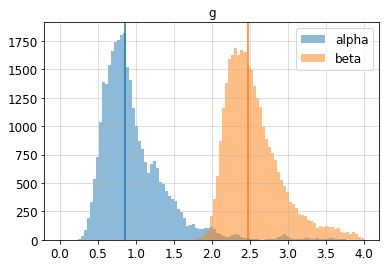

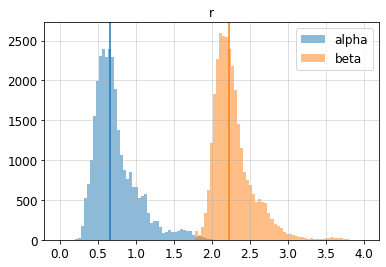

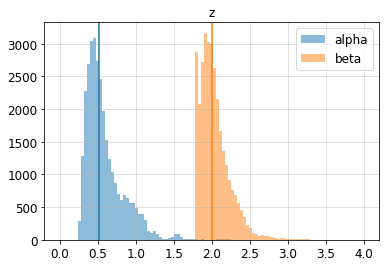

In [14]:
for band in ['g', 'r', 'z']:
    mask = moffat_params['filter']==band
    plt.hist(moffat_params['moffat_alpha'][mask], 101, alpha=0.5, range=(0, 4), label='alpha')
    plt.hist(moffat_params['moffat_beta'][mask], 101, alpha=0.5, range=(0, 4), label='beta')
    plt.axvline(medians[band+'_alpha'], lw=1.5, color='C0')
    plt.axvline(medians[band+'_beta'], lw=1.5, color='C1')
    plt.title(band)
    plt.grid(alpha=0.5)
    plt.legend()
    plt.show()